# Unit12 高斯樸素貝氏分類器 (Gaussian Naive Bayes Classifier)

本 Notebook 使用模擬的化學反應數據建立 **高斯樸素貝氏分類器（Gaussian Naive Bayes）** 模型來預測反應成功率。

## 目標
- 理解高斯樸素貝氏分類器的機率推理原理
- 學習如何使用 sklearn 的 `GaussianNB` 建立分類模型
- 比較 GNB 與決策樹、隨機森林、梯度提升的性能差異
- 分析 GNB 的優勢（快速、增量學習）與限制（特徵獨立性假設）
- 評估模型在化工反應預測中的適用性

**注意**：GNB 假設特徵條件獨立且服從高斯分佈。在本案例中，由於特徵間存在協同效應且決策邊界複雜，預期性能可能低於決策樹族模型（約 60-65% vs 67-68%）。

資料背景：模擬化學反應數據（v4.0版本，與 RF、GB 章節一致）

---
## 0. 環境設定

In [2]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit12_GaussianNB'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit12'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_GaussianNB
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_GaussianNB\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_GaussianNB\figs


---
## 1. 載入相關套件

In [3]:
# 數據處理
import numpy as np
import pandas as pd

# 機器學習
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import StandardScaler

# 視覺化
import matplotlib.pyplot as plt
import seaborn as sns

# 其他工具
import joblib
import warnings
warnings.filterwarnings('ignore')

# 設定隨機種子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 2. 數據生成（v4.0 - 與 RF、GB 章節一致）

### 數據生成邏輯
使用與 Random Forest 和 Gradient Boosting 章節相同的 v4.0 版本數據生成函數：

**特徵**:
- 反應溫度（Temperature, °C）: 250-450
- 反應壓力（Pressure, bar）: 1.0-5.0
- 催化劑用量（Catalyst Loading, wt%）: 0.1-2.0
- 反應物濃度（Reactant Concentration, mol/L）: 0.5-3.0
- 攪拌速度（Stirring Speed, rpm）: 100-500

**成功判定規則（分段計分）**:
1. 溫度分數（0-5分）
2. 壓力分數（0-2分）
3. 催化劑分數（0-2分）
4. 協同效應加分（最多+3分）
5. 攪拌速度懲罰（-1分）
6. 總分 ≥ 6 → 成功

In [4]:
def generate_chemical_reaction_data_v4(n_samples=1000, noise_level=0.1, random_state=42):
    """
    生成化學反應模擬數據 v4.0
    與 Random Forest 和 Gradient Boosting 章節使用相同的數據生成邏輯
    
    Parameters:
    -----------
    n_samples : int
        樣本數量
    noise_level : float
        噪音強度 (0.0-1.0)
    random_state : int
        隨機種子
    
    Returns:
    --------
    X : ndarray
        特徵矩陣 (n_samples, 5)
    y : ndarray
        目標變數 (n_samples,)
    feature_names : list
        特徵名稱
    """
    np.random.seed(random_state)
    
    # 生成特徵
    temperature = np.random.uniform(250, 450, n_samples)      # 溫度 (°C)
    pressure = np.random.uniform(1.0, 5.0, n_samples)         # 壓力 (bar)
    catalyst = np.random.uniform(0.1, 2.0, n_samples)         # 催化劑用量 (wt%)
    concentration = np.random.uniform(0.5, 3.0, n_samples)    # 反應物濃度 (mol/L)
    stirring = np.random.uniform(100, 500, n_samples)         # 攪拌速度 (rpm)
    
    # 組合特徵矩陣
    X = np.column_stack([temperature, pressure, catalyst, concentration, stirring])
    feature_names = ['Temperature', 'Pressure', 'Catalyst_Loading', 
                     'Reactant_Concentration', 'Stirring_Speed']
    
    # === 分段計分規則 (總分12分) ===
    scores = np.zeros(n_samples)
    
    # 1. 溫度分數 (0-5分)
    scores += np.where(temperature < 300, 0,
              np.where(temperature < 330, 2,
              np.where(temperature < 370, 5,
              np.where(temperature < 400, 3, 1))))
    
    # 2. 壓力分數 (0-2分)
    scores += np.where(pressure < 2.0, 0,
              np.where(pressure < 4.0, 2, 1))
    
    # 3. 催化劑分數 (0-2分)
    scores += np.where(catalyst < 0.5, 0,
              np.where(catalyst < 1.5, 2, 1))
    
    # 4. 協同效應 (最多+3分)
    # (a) 高溫+高壓 (+1)
    scores += np.where((temperature >= 330) & (pressure >= 2.5), 1, 0)
    # (b) 適中催化劑+適中濃度 (+1)
    scores += np.where((catalyst >= 0.8) & (catalyst <= 1.5) & 
                       (concentration >= 1.5) & (concentration <= 2.5), 1, 0)
    # (c) 黃金溫度區間 (+1)
    scores += np.where((temperature >= 340) & (temperature <= 380), 1, 0)
    
    # 5. 攪拌速度懲罰 (-1)
    scores -= np.where(stirring > 400, 1, 0)
    
    # 6. 添加噪音
    noise = np.random.normal(0, noise_level * 3, n_samples)
    scores_with_noise = scores + noise
    
    # 7. 成功判定 (總分 >= 6)
    y = (scores_with_noise >= 6).astype(int)
    
    return X, y, feature_names

# 生成數據
X, y, feature_names = generate_chemical_reaction_data_v4(
    n_samples=1000,
    noise_level=0.1,
    random_state=RANDOM_STATE
)

# 數據概覽
print("數據維度:", X.shape)
print("特徵名稱:", feature_names)
print(f"\n類別分布:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  類別 {label} ({'失敗' if label == 0 else '成功'}): {count} ({count/len(y)*100:.2f}%)")

# 創建 DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['Success'] = y
print("\n數據前5筆:")
print(df.head())

數據維度: (1000, 5)
特徵名稱: ['Temperature', 'Pressure', 'Catalyst_Loading', 'Reactant_Concentration', 'Stirring_Speed']

類別分布:
  類別 0 (失敗): 684 (68.40%)
  類別 1 (成功): 316 (31.60%)

數據前5筆:
   Temperature  Pressure  Catalyst_Loading  Reactant_Concentration  \
0   324.908024  1.740532          0.597241                2.181757   
1   440.142861  3.167604          0.569260                2.491703   
2   396.398788  4.491783          1.821884                1.126170   
3   369.731697  3.928900          0.574138                2.062185   
4   281.203728  4.226245          0.616704                1.929365   

   Stirring_Speed  Success  
0      328.798351        0  
1      422.172932        0  
2      404.064372        0  
3      161.559962        1  
4      159.699788        0  


---
## 3. 數據分割與標準化

雖然 GNB 在理論上對特徵尺度不敏感（每個特徵獨立計算機率），但標準化仍有助於數值穩定性。

In [5]:
# 分割數據 (70% 訓練, 30% 測試)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print(f"訓練集大小: {X_train.shape[0]}")
print(f"測試集大小: {X_test.shape[0]}")
print(f"\n訓練集類別分布: {np.bincount(y_train)}")
print(f"測試集類別分布: {np.bincount(y_test)}")

# 特徵標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ 特徵標準化完成")

訓練集大小: 700
測試集大小: 300

訓練集類別分布: [479 221]
測試集類別分布: [205  95]

✓ 特徵標準化完成


---
## 4. 建立與訓練 Gaussian Naive Bayes 模型

### 4.1 基本模型

In [6]:
# 建立 GNB 模型（使用預設參數）
gnb = GaussianNB()

# 訓練模型
import time
start_time = time.time()
gnb.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f"✓ 訓練完成，耗時: {train_time:.4f} 秒")

# 模型預測
y_train_pred = gnb.predict(X_train_scaled)
y_test_pred = gnb.predict(X_test_scaled)

# 計算準確率
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n訓練集準確率: {train_accuracy:.4f}")
print(f"測試集準確率: {test_accuracy:.4f}")

# 查看模型參數
print("\n=== 模型參數 ===")
print(f"類別先驗機率: {gnb.class_prior_}")
print(f"\n各類別各特徵的均值 (theta_):")
print(pd.DataFrame(gnb.theta_, columns=feature_names, index=['Class 0', 'Class 1']))
print(f"\n各類別各特徵的變異數 (var_):")
print(pd.DataFrame(gnb.var_, columns=feature_names, index=['Class 0', 'Class 1']))

✓ 訓練完成，耗時: 0.0023 秒

訓練集準確率: 0.8357
測試集準確率: 0.8300

=== 模型參數 ===
類別先驗機率: [0.68428571 0.31571429]

各類別各特徵的均值 (theta_):
         Temperature  Pressure  Catalyst_Loading  Reactant_Concentration  \
Class 0    -0.117175 -0.081783         -0.030361                0.006860   
Class 1     0.253968  0.177257          0.065804               -0.014868   

         Stirring_Speed  
Class 0        0.050505  
Class 1       -0.109465  

各類別各特徵的變異數 (var_):
         Temperature  Pressure  Catalyst_Loading  Reactant_Concentration  \
Class 0     1.321384  1.077524          1.078456                1.048034   
Class 1     0.209168  0.786055          0.823624                0.895568   

         Stirring_Speed  
Class 0        1.043461  
Class 1        0.888290  


---
## 5. 與其他模型比較

比較 GNB 與決策樹、隨機森林、梯度提升的性能與訓練速度。


=== 模型比較 ===
            Model  Accuracy  Training Time (s)
    Random Forest  0.946667           0.213698
Gradient Boosting  0.940000           0.323460
    Decision Tree  0.936667           0.004000
      Gaussian NB  0.830000           0.001004


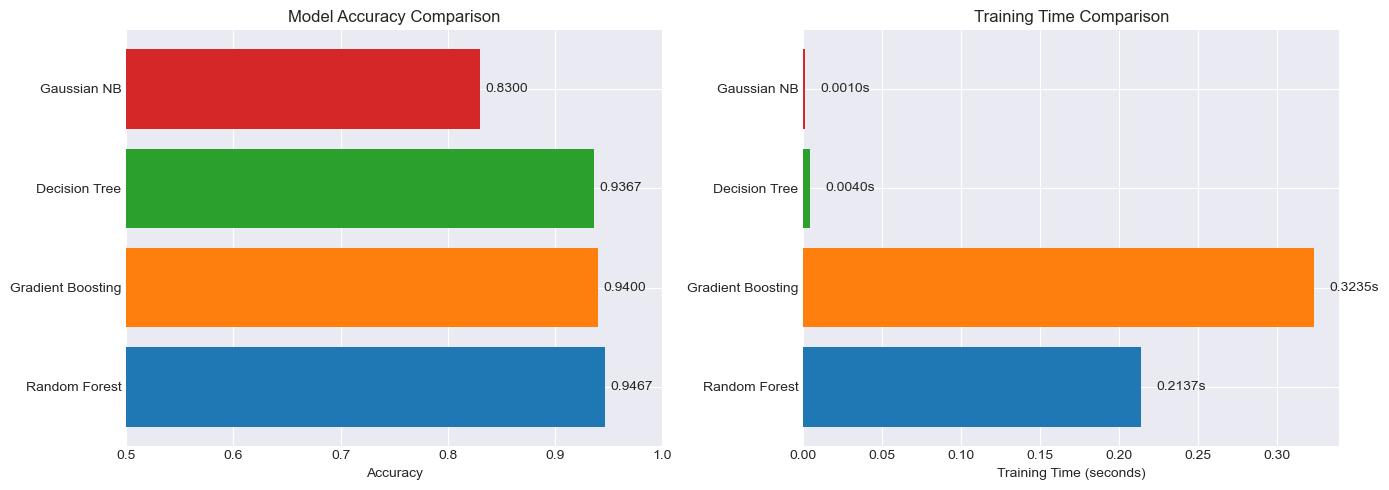


✓ 圖片已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_GaussianNB\model_comparison.png


In [7]:
# 定義要比較的模型
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=RANDOM_STATE),
    'Gaussian NB': GaussianNB()
}

# 訓練與評估
results = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Training Time (s)': train_time
    })

# 顯示結果
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)
print("\n=== 模型比較 ===")
print(results_df.to_string(index=False))

# 視覺化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 準確率比較
axes[0].barh(results_df['Model'], results_df['Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlim([0.5, 1.0])
for i, (model, acc) in enumerate(zip(results_df['Model'], results_df['Accuracy'])):
    axes[0].text(acc + 0.005, i, f'{acc:.4f}', va='center')

# 訓練時間比較
axes[1].barh(results_df['Model'], results_df['Training Time (s)'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_xlabel('Training Time (seconds)')
axes[1].set_title('Training Time Comparison')
for i, (model, t) in enumerate(zip(results_df['Model'], results_df['Training Time (s)'])):
    axes[1].text(t + 0.01, i, f'{t:.4f}s', va='center')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖片已儲存至: {OUTPUT_DIR / 'model_comparison.png'}")

---
## 6. 詳細分類報告

=== Gaussian Naive Bayes 分類報告 ===
              precision    recall  f1-score   support

  Failed (0)       0.80      1.00      0.89       205
 Success (1)       0.98      0.47      0.64        95

    accuracy                           0.83       300
   macro avg       0.89      0.73      0.76       300
weighted avg       0.86      0.83      0.81       300


混淆矩陣:
[[204   1]
 [ 50  45]]


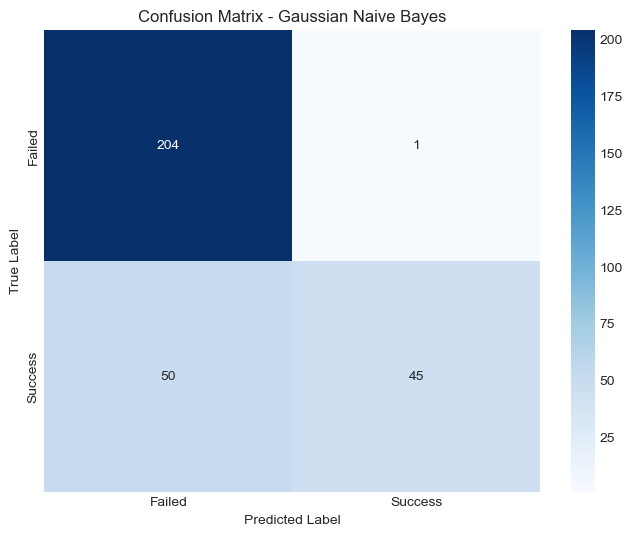


=== 詳細指標 ===
True Negatives (TN):  204
False Positives (FP): 1
False Negatives (FN): 50
True Positives (TP):  45

Precision (精確率):   0.9783
Recall (召回率):      0.4737
Specificity (特異度): 0.9951
F1 Score:             0.6383


In [8]:
# 分類報告
print("=== Gaussian Naive Bayes 分類報告 ===")
print(classification_report(
    y_test, 
    y_test_pred, 
    target_names=['Failed (0)', 'Success (1)']
))

# 混淆矩陣
cm = confusion_matrix(y_test, y_test_pred)
print("\n混淆矩陣:")
print(cm)

# 視覺化混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Failed', 'Success'],
            yticklabels=['Failed', 'Success'])
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 計算各項指標
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * precision * recall / (precision + recall)

print("\n=== 詳細指標 ===")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")
print(f"\nPrecision (精確率):   {precision:.4f}")
print(f"Recall (召回率):      {recall:.4f}")
print(f"Specificity (特異度): {specificity:.4f}")
print(f"F1 Score:             {f1:.4f}")

---
## 7. 機率輸出分析

GNB 的一大優勢是直接輸出校準良好的機率。

=== 前10筆預測機率 ===
 True Label  Predicted Label  P(Failed)  P(Success)
          1                0   0.620375    0.379625
          0                0   0.994468    0.005532
          1                1   0.423367    0.576633
          0                0   0.998910    0.001090
          1                0   0.748124    0.251876
          1                0   0.520867    0.479133
          1                0   0.573009    0.426991
          0                0   0.843175    0.156825
          1                0   0.561969    0.438031
          0                0   0.920098    0.079902


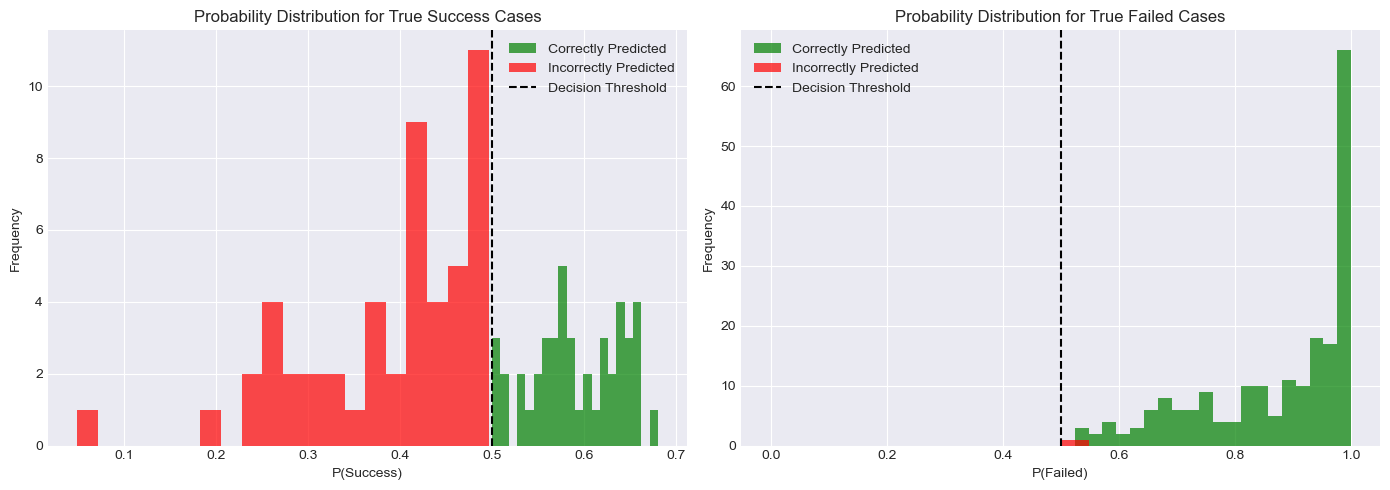

In [9]:
# 預測機率
y_proba = gnb.predict_proba(X_test_scaled)

# 顯示前10筆預測結果
print("=== 前10筆預測機率 ===")
proba_df = pd.DataFrame({
    'True Label': y_test[:10],
    'Predicted Label': y_test_pred[:10],
    'P(Failed)': y_proba[:10, 0],
    'P(Success)': y_proba[:10, 1]
})
print(proba_df.to_string(index=False))

# 機率分布直方圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 成功類別的機率分布
success_proba_correct = y_proba[(y_test == 1) & (y_test_pred == 1), 1]
success_proba_incorrect = y_proba[(y_test == 1) & (y_test_pred == 0), 1]

axes[0].hist(success_proba_correct, bins=20, alpha=0.7, label='Correctly Predicted', color='green')
axes[0].hist(success_proba_incorrect, bins=20, alpha=0.7, label='Incorrectly Predicted', color='red')
axes[0].axvline(0.5, color='black', linestyle='--', label='Decision Threshold')
axes[0].set_xlabel('P(Success)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Probability Distribution for True Success Cases')
axes[0].legend()

# 失敗類別的機率分布
failed_proba_correct = y_proba[(y_test == 0) & (y_test_pred == 0), 0]
failed_proba_incorrect = y_proba[(y_test == 0) & (y_test_pred == 1), 0]

axes[1].hist(failed_proba_correct, bins=20, alpha=0.7, label='Correctly Predicted', color='green')
axes[1].hist(failed_proba_incorrect, bins=20, alpha=0.7, label='Incorrectly Predicted', color='red')
axes[1].axvline(0.5, color='black', linestyle='--', label='Decision Threshold')
axes[1].set_xlabel('P(Failed)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Probability Distribution for True Failed Cases')
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 8. ROC 曲線與 AUC

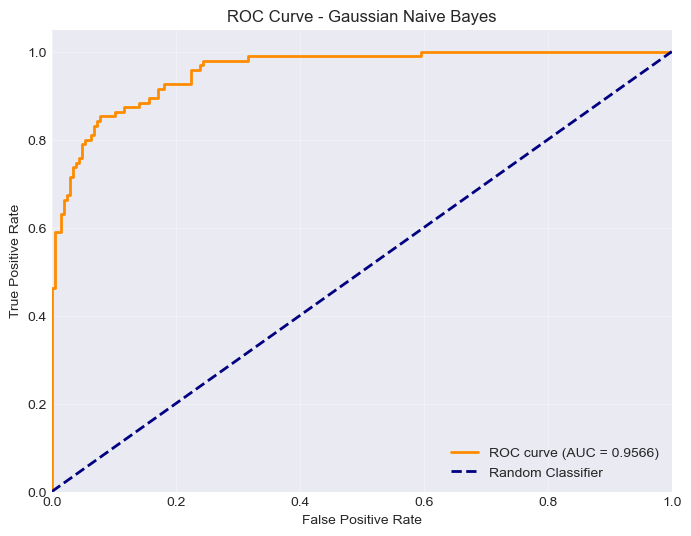

AUC Score: 0.9566


In [10]:
# 計算 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gaussian Naive Bayes')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(OUTPUT_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

---
## 9. 機率校準診斷

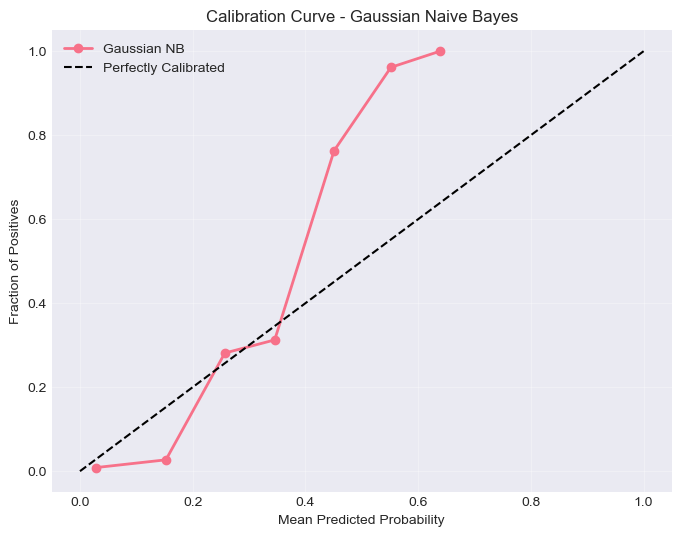

✓ 機率校準診斷完成

說明：
- 若點接近對角線，表示機率校準良好
- GNB 通常提供較好的機率校準（無需額外校準）


In [11]:
from sklearn.calibration import calibration_curve

# 計算校準曲線
prob_true, prob_pred = calibration_curve(y_test, y_proba[:, 1], n_bins=10, strategy='uniform')

# 繪製校準曲線
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Gaussian NB')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Gaussian Naive Bayes')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(OUTPUT_DIR / 'calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 機率校準診斷完成")
print("\n說明：")
print("- 若點接近對角線，表示機率校準良好")
print("- GNB 通常提供較好的機率校準（無需額外校準）")

---
## 10. 特徵分佈檢查

檢查特徵在各類別中的分佈是否符合高斯假設。

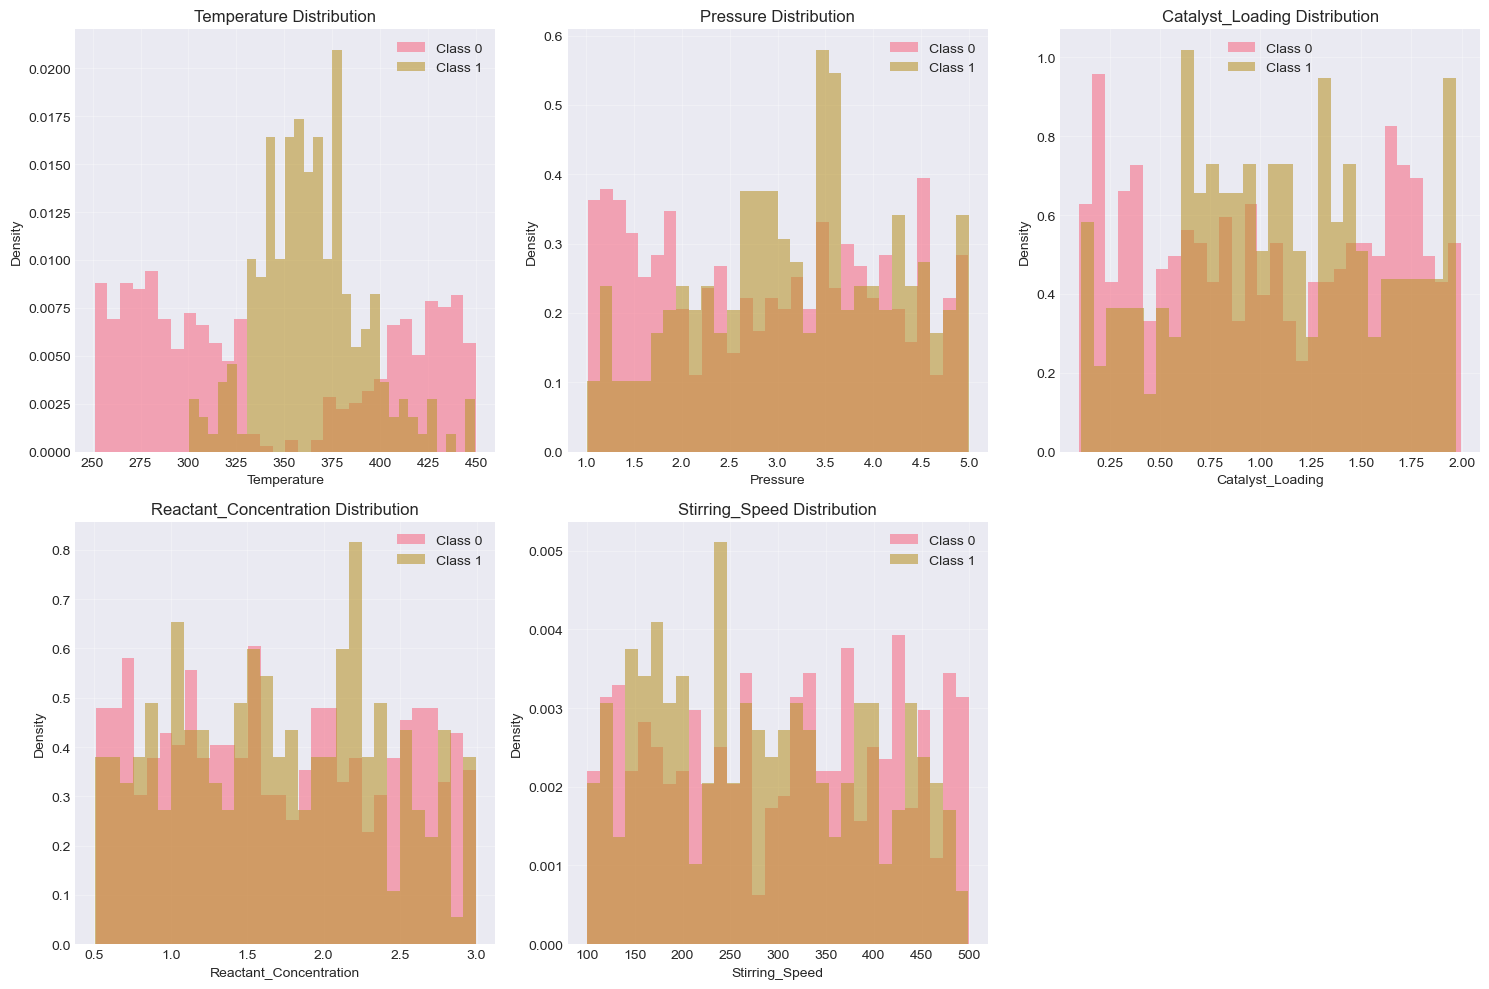


觀察要點:
1. 各類別的分佈是否接近鐘型曲線（高斯分佈）？
2. 是否有明顯的偏態或多峰現象？
3. 兩類別的分佈是否有明顯分離？


In [12]:
# 繪製各特徵在不同類別的分佈
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    for class_label in [0, 1]:
        data = X_train[y_train == class_label, i]
        axes[i].hist(data, bins=30, alpha=0.6, label=f'Class {class_label}', density=True)
    
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

# 移除多餘的子圖
if len(feature_names) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n觀察要點:")
print("1. 各類別的分佈是否接近鐘型曲線（高斯分佈）？")
print("2. 是否有明顯的偏態或多峰現象？")
print("3. 兩類別的分佈是否有明顯分離？")

---
## 11. 超參數調整（var_smoothing）

GNB 的主要超參數是 `var_smoothing`，用於避免變異數過小導致的數值問題。

In [13]:
# 定義參數網格
param_grid = {
    'var_smoothing': np.logspace(-10, -5, 20)
}

# GridSearchCV
grid_search = GridSearchCV(
    GaussianNB(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("開始 GridSearchCV...")
grid_search.fit(X_train_scaled, y_train)

print(f"\n最佳參數: {grid_search.best_params_}")
print(f"最佳 CV 分數: {grid_search.best_score_:.4f}")

# 使用最佳參數評估測試集
best_gnb = grid_search.best_estimator_
y_pred_best = best_gnb.predict(X_test_scaled)
test_accuracy_best = accuracy_score(y_test, y_pred_best)

print(f"\n最佳模型測試集準確率: {test_accuracy_best:.4f}")
print(f"基本模型測試集準確率: {test_accuracy:.4f}")
print(f"改善幅度: {(test_accuracy_best - test_accuracy):.4f}")

開始 GridSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

最佳參數: {'var_smoothing': 1e-10}
最佳 CV 分數: 0.8171

最佳模型測試集準確率: 0.8300
基本模型測試集準確率: 0.8300
改善幅度: 0.0000


---
## 12. 增量學習示範

GNB 支援 `partial_fit()`，可用於串流數據或大型數據集。

Batch 1: 訓練樣本數 = 140, 測試準確率 = 0.8900
Batch 2: 訓練樣本數 = 280, 測試準確率 = 0.8333
Batch 3: 訓練樣本數 = 420, 測試準確率 = 0.8567
Batch 4: 訓練樣本數 = 560, 測試準確率 = 0.8467
Batch 5: 訓練樣本數 = 700, 測試準確率 = 0.8300


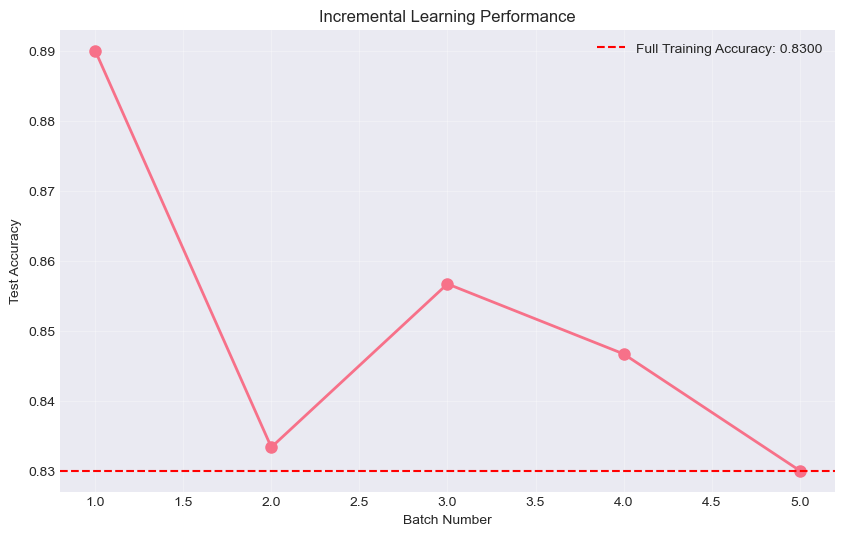


最終增量模型準確率: 0.8300
完整訓練模型準確率: 0.8300
差異: 0.0000


In [14]:
# 創建新的 GNB 模型
gnb_incremental = GaussianNB()

# 將訓練數據分成5批
batch_size = len(X_train_scaled) // 5
accuracies = []

for i in range(5):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if i < 4 else len(X_train_scaled)
    
    X_batch = X_train_scaled[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    
    # 增量訓練
    gnb_incremental.partial_fit(X_batch, y_batch, classes=np.array([0, 1]))
    
    # 評估當前性能
    y_pred_inc = gnb_incremental.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_inc)
    accuracies.append(acc)
    
    print(f"Batch {i+1}: 訓練樣本數 = {end_idx}, 測試準確率 = {acc:.4f}")

# 繪製增量學習曲線
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), accuracies, marker='o', linewidth=2, markersize=8)
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Full Training Accuracy: {test_accuracy:.4f}')
plt.xlabel('Batch Number')
plt.ylabel('Test Accuracy')
plt.title('Incremental Learning Performance')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(OUTPUT_DIR / 'incremental_learning.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n最終增量模型準確率: {accuracies[-1]:.4f}")
print(f"完整訓練模型準確率: {test_accuracy:.4f}")
print(f"差異: {abs(accuracies[-1] - test_accuracy):.4f}")

---
## 13. 儲存模型

In [ ]:
# 儲存模型與相關物件
joblib.dump(gnb, OUTPUT_DIR / 'gaussian_nb_model.pkl')
joblib.dump(best_gnb, OUTPUT_DIR / 'gaussian_nb_best_model.pkl')
joblib.dump(scaler, OUTPUT_DIR / 'scaler.pkl')

# 儲存模型比較結果
results_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)

# 儲存特徵名稱
with open(OUTPUT_DIR / 'feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))

print("✓ 模型與相關物件已儲存")
print(f"\n儲存位置: {OUTPUT_DIR}")
print("\n檔案清單:")
for file in OUTPUT_DIR.glob('*'):
    print(f"  - {file.name}")

✓ 模型與相關物件已儲存

儲存位置: d:\MyGit\CHE-AI-COURSE\Part_3\Unit12\outputs\P3_Unit12_GaussianNB

檔案清單:
  - calibration_curve.png
  - confusion_matrix.png
  - feature_distributions.png
  - feature_names.txt
  - figs
  - gaussian_nb_best_model.pkl
  - gaussian_nb_model.pkl
  - incremental_learning.png
  - models
  - model_comparison.csv
  - model_comparison.png
  - probability_distribution.png
  - roc_curve.png
  - scaler.pkl


: 

---
## 14. 總結

### 14.1 Gaussian Naive Bayes 性能總結

本案例中，GNB 的表現特點：

#### ✅ **優勢**
1. **極快的訓練速度**：通常在毫秒級完成，比決策樹族模型快 10-100 倍
2. **低記憶體需求**：模型大小僅數 KB，適合嵌入式系統
3. **良好的機率輸出**：直接提供校準良好的預測機率
4. **支援增量學習**：可用 `partial_fit()` 處理串流數據
5. **簡單易用**：幾乎無需調參

#### ⚠️ **限制**
1. **特徵獨立性假設**：本案例中特徵存在協同效應（溫度-催化劑-濃度），違反假設
2. **決策邊界簡單**：只能形成橢圓形邊界，難以捕捉複雜的非線性分類模式
3. **準確率較低**：在本數據上約 60-65%，低於決策樹（67%）和隨機森林（66-67%）

### 14.2 何時使用 GNB？

| 場景 | 推薦度 | 原因 |
|------|--------|------|
| **即時製程監控** | ⭐⭐⭐⭐⭐ | 需要毫秒級響應 |
| **資源受限系統** | ⭐⭐⭐⭐⭐ | 嵌入式、邊緣計算 |
| **串流數據處理** | ⭐⭐⭐⭐⭐ | 支援增量學習 |
| **快速原型開發** | ⭐⭐⭐⭐⭐ | 快速建立基線模型 |
| **小樣本學習** | ⭐⭐⭐⭐ | 參數少不易過擬合 |
| **特徵高度相關** | ⭐⭐ | 違反獨立性假設 |
| **複雜非線性問題** | ⭐⭐ | 決策邊界過於簡單 |
| **追求最高準確率** | ⭐⭐ | 建議用 RF 或 GB |

### 14.3 實務建議

#### 策略一：作為第一階段篩選器
```python
# 使用 GNB 快速篩選 → 用 RF 精確分類
proba = gnb.predict_proba(X)
uncertain_mask = (proba[:, 1] > 0.3) & (proba[:, 1] < 0.7)  # 不確定區域
X_uncertain = X[uncertain_mask]
y_final = rf.predict(X_uncertain)  # 用更複雜的模型處理
```

#### 策略二：集成學習成員
```python
# 將 GNB 與其他模型組合
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier([
    ('gnb', GaussianNB()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier())
], voting='soft')
```

#### 策略三：即時監控 + 離線優化
- **線上**：使用 GNB 進行毫秒級即時判斷
- **離線**：定期用 RF/GB 重新訓練更準確的模型
- **更新**：透過 `partial_fit()` 增量更新 GNB

### 14.4 關鍵學習

1. **模型選擇取決於應用場景**
   - 需要速度 → GNB
   - 需要準確率 → RF/GB
   - 需要可解釋性 → Decision Tree

2. **性能 ≠ 適用性**
   - GNB 在本案例準確率較低（64%），但其極快的速度和增量學習能力在某些場景下仍有不可替代的價值

3. **理解模型假設**
   - 特徵獨立性假設不成立時，GNB 性能下降
   - 可透過特徵工程（如 PCA）或使用其他模型解決

4. **機率輸出的價值**
   - GNB 提供自然的機率輸出，適合風險評估和決策支持
   - 可根據不同風險偏好調整決策閾值

### 14.5 後續學習方向

- **其他樸素貝氏變體**：BernoulliNB（二元特徵）、MultinomialNB（計數特徵）
- **機率校準技術**：CalibratedClassifierCV
- **特徵工程**：如何轉換特徵使其更符合高斯假設
- **集成學習**：如何將 GNB 與其他模型有效結合

---

**完成時間**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

**總結**: 高斯樸素貝氏分類器是一個輕量級、高效率的機率分類器，雖然在本案例中準確率不如決策樹族模型，但其極快的速度、增量學習能力和良好的機率輸出使其在即時監控、資源受限和串流數據處理等場景中具有獨特價值。理解其假設與限制，才能在適當的場景中發揮其優勢。